In [57]:
using JLD2, Flux, CairoMakie, JLD2, Random
include("DenseNTk.jl"); include("FastNTKMethods.jl")

Random.seed!(123)

x = zeros(2,10)
x[1,:] = randn(10)
x[2,:] = randn(10)
f = x->exp.(sin.(x[1,:]*pi)+cos.(x[2,:]*pi))
y = f(x)'

act = relu; N1=10_000; InDim = size(x)[1]; OutDim = 1
model = Chain(DenseNTK(InDim=>N1,activation),DenseNTK(N1=>OutDim))|>f64
params_0 = deepcopy(Flux.params(model))
Loss(model,x,y) = Flux.mse(y,model(x))
data = [(x,y)]; n_epoch = 10_000

K = kernel(model,x,false); eig = eigen(K).values; lr_opt1 = 1/eig[end]; lr_opt2 = 1/eig[end] * 5
display(model)

Chain(
  DenseNTK([-1.1985193490982056 -1.7679489850997925; 1.825571894645691 -0.5722506642341614; … ; 0.10046763718128204 0.5878720879554749; -0.7963129878044128 -0.9606517553329468], [-0.23030425608158112, 0.32632067799568176, -0.15559285879135132, -0.051727086305618286, 1.072257161140442, 0.7304956316947937, 1.7996001243591309, -0.6824083924293518, 0.9668324589729309, 0.3711014986038208  …  0.9318212270736694, 0.24962221086025238, 1.4504635334014893, -0.7583998441696167, -0.7983369827270508, -0.24328702688217163, -0.11433707922697067, 1.2901029586791992, 0.8345562815666199, -0.2818036377429962], NNlib.relu),  # 30_000 parameters
  DenseNTK([0.418224960565567 1.9341634511947632 … 0.6288605332374573 0.7351447939872742], [-0.13086111843585968], identity),  # 10_001 parameters
)                   # Total: 4 arrays, 40_001 parameters, 312.805 KiB.

In [58]:
L_opt1 = []
@showprogress for epoch = 1:n_epoch
    Flux.train!(Loss,model,data,Descent(lr_opt1))
    push!(L_opt1,Loss(model,x,y))
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [59]:
L_opt2 = []

for i = 1:4
    Flux.params(model)[i] .= params_0[i]
end

display(model)

@showprogress for epoch = 1:n_epoch
    Flux.train!(Loss,model,data,Descent(lr_opt2))
    push!(L_opt2,Loss(model,x,y))
end

Chain(
  DenseNTK([-1.1985193490982056 -1.7679489850997925; 1.825571894645691 -0.5722506642341614; … ; 0.10046763718128204 0.5878720879554749; -0.7963129878044128 -0.9606517553329468], [-0.23030425608158112, 0.32632067799568176, -0.15559285879135132, -0.051727086305618286, 1.072257161140442, 0.7304956316947937, 1.7996001243591309, -0.6824083924293518, 0.9668324589729309, 0.3711014986038208  …  0.9318212270736694, 0.24962221086025238, 1.4504635334014893, -0.7583998441696167, -0.7983369827270508, -0.24328702688217163, -0.11433707922697067, 1.2901029586791992, 0.8345562815666199, -0.2818036377429962], NNlib.relu),  # 30_000 parameters
  DenseNTK([0.418224960565567 1.9341634511947632 … 0.6288605332374573 0.7351447939872742], [-0.13086111843585968], identity),  # 10_001 parameters
)                   # Total: 4 arrays, 40_001 parameters, 312.805 KiB.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


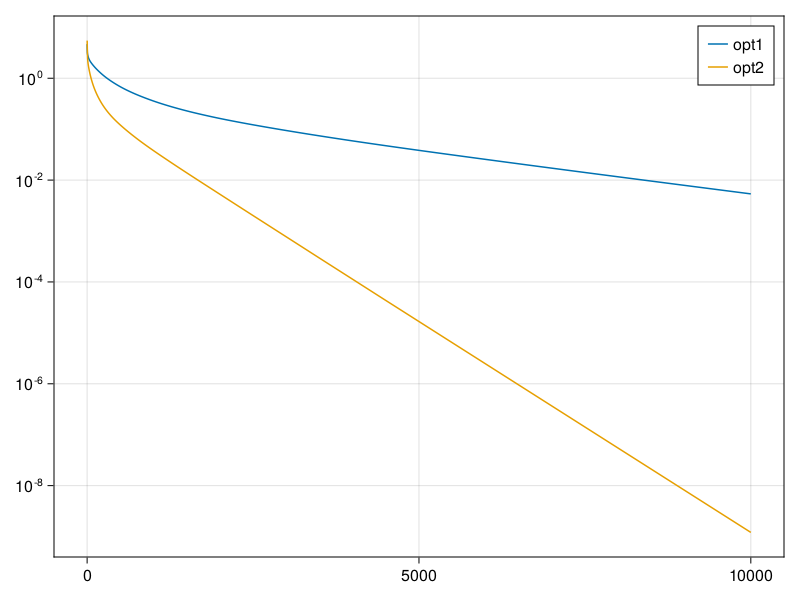

In [60]:
fig = Figure(); ax = Axis(fig[1,1],yscale=log10); 
CairoMakie.lines!(ax,Float64.(hcat(1:10000))[:],Float64.(L_opt1)[:],label="opt1");
CairoMakie.lines!(ax,Float64.(hcat(1:10000))[:],Float64.(L_opt2)[:],label="opt2")
axislegend(position=:rt)
fig